<a href="https://colab.research.google.com/github/kariajh/Analisis_tiempo_maraton/blob/main/Marat%C3%B3n_Predicci%C3%B3n_Tiempos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion de tiempos de maraton

Se busca predecir el tiempo de llegada de un maratonista

# Librerias

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import io

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.ticker as ticker

# Preprocesado y modelado
# ==============================================================================
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from statsmodels.stats.anova import anova_lm
from scipy import stats
from xgboost import XGBRegressor

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Datos

Primero cargamos el archivo CSV.

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving MarathonData.csv to MarathonData.csv


In [ ]:
datos_maraton=pd.read_csv(io.BytesIO(uploaded['MarathonData.csv']))

Id:identificador

Marathon: Maraton que se corrio

Name: Nombre del corredor

Category: 

km4week: cuantos kilometros entreno el corredor durante las ultimas cuatro semanas 

sp4week: Velocidad media en el entrenamiento km4week

CrossTraining: Si el corredor ademas del maraton se dedica al ciclismo

Wall21: El tiempo que el corredor marco a media maraton

MarathonTime: Tiempo de marcacion a la linea de meta. Valor a predecir.

# Analisis exploratorio

Antes de entrenar un modelo predictivo, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores.

Además, este análisis inicial puede dar pistas sobre qué variables son adecuadas como predictores en un modelo

In [ ]:
datos_maraton[:3]

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.8,14.434783,NaN,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.6,13.674419,NaN,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.7,13.520436,NaN,1.30,2.66,A


Tipo de cada columna

In [ ]:
datos_maraton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             87 non-null     int64  
 1   Marathon       87 non-null     object 
 2   Name           87 non-null     object 
 3   Category       81 non-null     object 
 4   km4week        87 non-null     float64
 5   sp4week        87 non-null     float64
 6   CrossTraining  13 non-null     object 
 7   Wall21         87 non-null     object 
 8   MarathonTime   87 non-null     float64
 9   CATEGORY       87 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 6.9+ KB


La columna Wall21 no tiene el tipo adecuado

# Número de observaciones y valores ausentes

Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores ausentes son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas. Aunque la imputación de valores ausentes es parte del preprocesado y, por lo tanto, debe de aprenderse únicamente con los datos de entrenamiento, su identificación se tiene que realizar antes de separar los datos para asegurar que se establecen todas las estrategias de imputación necesarias.

In [ ]:
datos_maraton.isna().sum().sort_values()

id                0
Marathon          0
Name              0
km4week           0
sp4week           0
Wall21            0
MarathonTime      0
CATEGORY          0
Category          6
CrossTraining    74
dtype: int64

Lo vamos a rellenar con ceros

In [ ]:
datos_maraton["CrossTraining"] = datos_maraton["CrossTraining"].fillna(0)
datos_maraton

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.8,14.434783,0,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.6,13.674419,0,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.7,13.520436,0,1.30,2.66,A
3,4,Prague17,Daniel Or lek,M45,137.5,12.258544,0,1.32,2.68,A
4,5,Prague17,Luk ? Mr zek,MAM,84.6,13.945055,0,1.36,2.74,A
...,...,...,...,...,...,...,...,...,...,...
82,83,Prague17,Stefano Vegliani,M55,50.0,10.830325,0,2.02,3.93,D
83,84,Prague17,Andrej Madliak,M40,33.6,10.130653,ciclista 3h,1.94,3.93,D
84,85,Prague17,Yoi Ohsako,M40,55.4,11.043189,0,1.94,3.94,D
85,86,Prague17,Simon Dunn,M45,33.2,11.066667,0,2.05,3.95,D


Elimino los valores restantes

In [ ]:
datos_maraton = datos_maraton.dropna(how='any')
datos_maraton[:3]

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.8,14.434783,0,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.6,13.674419,0,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.7,13.520436,0,1.30,2.66,A


# Variable respuesta

Estudiamos la distribución de la variable respuesta, ya que es lo que interesa predecir. La variable MarathonTime tiene una distribución que tiende a la simetria, entre el primer corredor y los restantes hay una distancia considerable, luego se hace mas uniforme.


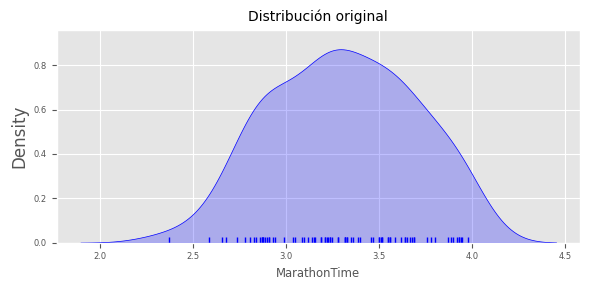

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.kdeplot(
    datos_maraton.MarathonTime,
    fill    = True,
    color   = "blue",
)
sns.rugplot(
    datos_maraton.MarathonTime,
    color   = "blue",
)
axes.set_title("Distribución original", fontsize = 'medium')
axes.set_xlabel('MarathonTime', fontsize='small') 
axes.tick_params(labelsize = 6)

fig.tight_layout()

# Variables numericas

Pasamos de "object" a "numerico"

In [ ]:
datos_maraton['Wall21']=pd.to_numeric(datos_maraton['Wall21'],errors='coerce')

In [ ]:
pd.set_option('display.float_format',lambda x: '%.2f' % x)
datos_maraton.select_dtypes(include=['float64', 'int']).describe()

,id,km4week,sp4week,Wall21,MarathonTime
count,81.00,81.00,81.00,81.00,81.00
mean,43.28,62.65,149.31,1.63,3.31
std,25.49,26.84,1234.77,0.21,0.38
min,1.00,17.90,8.03,1.16,2.37
25%,21.00,45.20,11.57,1.45,2.99
50%,43.00,59.10,12.16,1.62,3.32
75%,65.00,78.20,12.88,1.76,3.59
max,87.00,137.50,11125.00,2.05,3.98


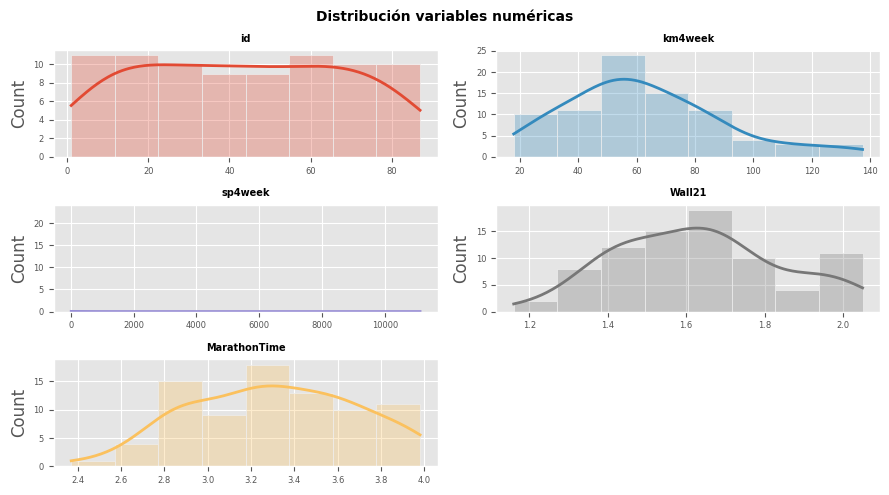

In [ ]:
# Gráfico de distribución para cada variable numérica

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numericas = datos_maraton.select_dtypes(include=['float64', 'int']).columns
#columnas_numericas = columnas_numericas.drop('MarathonTime')

for i, colum in enumerate(columnas_numericas):
    sns.histplot(
        data     = datos_maraton,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    # Se eliminan los axes vacíos
for i in [5]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

Eliminamos las columnas que no tienen sentido.

In [ ]:
datos_maraton = datos_maraton.drop(columns=['Name'])
datos_maraton = datos_maraton.drop(columns=['id'])
datos_maraton = datos_maraton.drop(columns=['Marathon'])
datos_maraton = datos_maraton.drop(columns=['CATEGORY'])
datos_maraton[:3]

,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,MAM,132.80,14.43,0,1.16,2.37
1,MAM,68.60,13.67,0,1.23,2.59
2,MAM,82.70,13.52,0,1.30,2.66


# Correlación variables numéricas

In [ ]:
# Correlación entre columnas numéricas

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos_maraton.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(5)

,variable_1,variable_2,r,abs_r
11,Wall21,MarathonTime,0.97,0.97
14,MarathonTime,Wall21,0.97,0.97
3,km4week,MarathonTime,-0.63,0.63
12,MarathonTime,km4week,-0.63,0.63
2,km4week,Wall21,-0.58,0.58


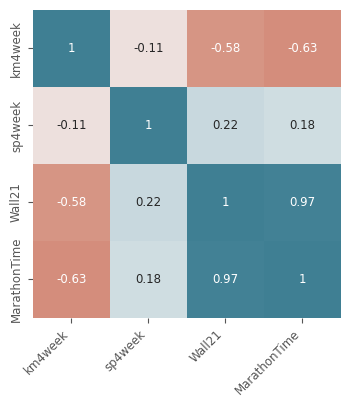

In [ ]:
# Heatmap matriz de correlaciones

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8.5},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8.5)

Previamente se llego a identificar un outlier en los valores de la columna sp4week, asi que eliminamos dicho valor

In [ ]:
datos_maraton=datos_maraton.query('sp4week<1000')

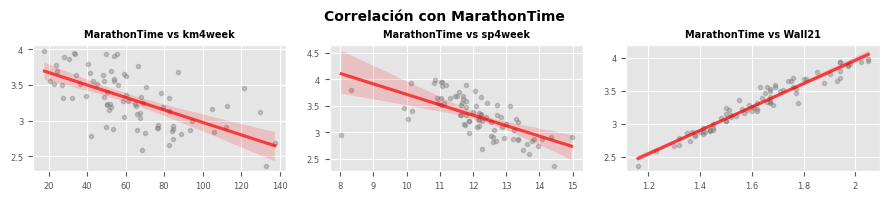

In [ ]:
# Gráfico de distribución para cada variable numérica

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 2))
axes = axes.flat
corr_numericas = datos_maraton.select_dtypes(include=['float64', 'int']).columns
corr_numericas = corr_numericas.drop('MarathonTime')

for i, colum in enumerate(corr_numericas):
    sns.regplot(
        x           = datos_maraton[colum],
        y           = datos_maraton['MarathonTime'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"MarathonTime vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.8)
fig.suptitle('Correlación con MarathonTime', fontsize = 10, fontweight = "bold");

Observamos que:

*   Los maratonistas que realizan largas distancias durante el entrenamiento, tienden a acortar los tiempos a la linea de llegada. Esto puede deberse a que cuando se aumenta gradualmente la distancia, tambien se adquiere mayor resistencia.

*   Un aumento en la velocidad media durante el entrenamiento reduce el tiempo en completar la maraton. 


# Variables cualitativas

Vamos a tratar los datos no numericos

In [ ]:
# Variables cualitativas (tipo object)
datos_maraton.select_dtypes(include=['object']).describe()

,Category,CrossTraining
count,80,80
unique,6,6
top,MAM,0
freq,39,68


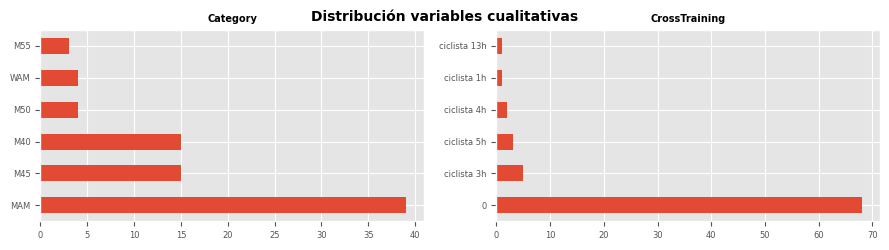

In [ ]:
# Gráfico para cada variable cualitativa

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 2.5))
axes = axes.flat
columnas_object = datos_maraton.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos_maraton[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

# Encodeamos las variables categoricas

Usamos one-hot encoding

In [ ]:
datos_maraton = pd.get_dummies(datos_maraton, columns=["CrossTraining","Category"])
datos_maraton.head()

,km4week,sp4week,Wall21,MarathonTime,CrossTraining_0,CrossTraining_ciclista 13h,CrossTraining_ciclista 1h,CrossTraining_ciclista 3h,CrossTraining_ciclista 4h,CrossTraining_ciclista 5h,Category_M40,Category_M45,Category_M50,Category_M55,Category_MAM,Category_WAM
0,132.80,14.43,1.16,2.37,1,0,0,0,0,0,0,0,0,0,1,0
1,68.60,13.67,1.23,2.59,1,0,0,0,0,0,0,0,0,0,1,0
2,82.70,13.52,1.30,2.66,1,0,0,0,0,0,0,0,0,0,1,0
3,137.50,12.26,1.32,2.68,1,0,0,0,0,0,0,1,0,0,0,0
4,84.60,13.95,1.36,2.74,1,0,0,0,0,0,0,0,0,0,1,0


# Heatmap de correlación con todas las variables numéricas

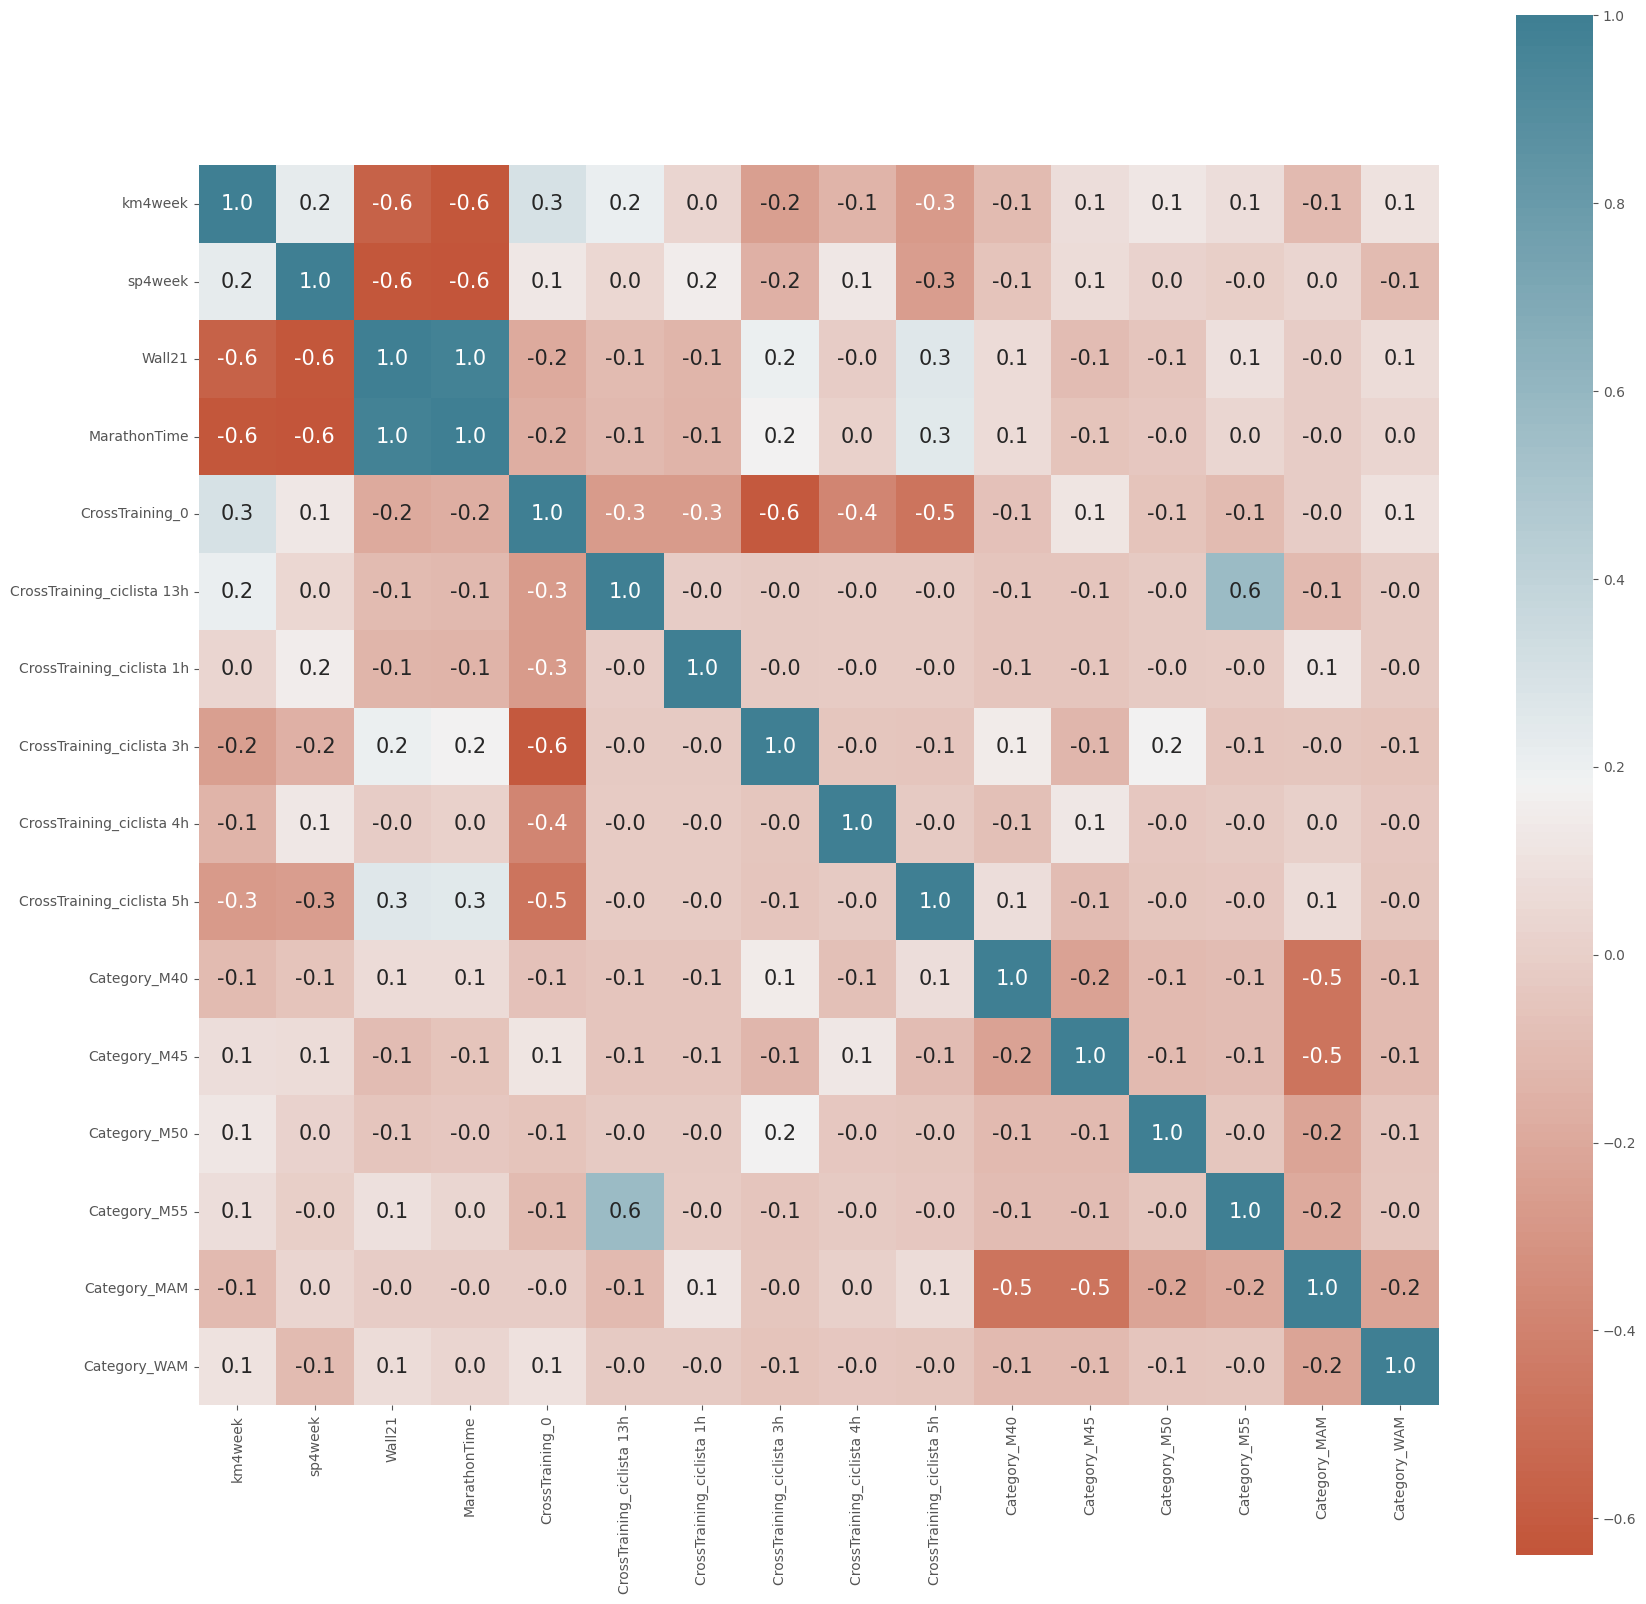

In [ ]:
corr = datos_maraton.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True,cmap= sns.diverging_palette(20, 220, n=200),fmt='.1f', annot=True, annot_kws={'size':15})
ax.tick_params(labelsize = 25)

# Modelos de Machine Learning

Separamos los datos entrenamiento (80%) y test (20%)

In [ ]:
def split_data (df):
    X = df.drop('MarathonTime', axis=1)
    y = df.loc[:, ['MarathonTime']]
    return train_test_split(X, y, test_size=0.2, random_state=3)

In [ ]:
datos_maraton.columns

Index(['km4week', 'sp4week', 'Wall21', 'MarathonTime', 'CrossTraining_0',
       'CrossTraining_ciclista 13h', 'CrossTraining_ciclista 1h',
       'CrossTraining_ciclista 3h', 'CrossTraining_ciclista 4h',
       'CrossTraining_ciclista 5h', 'Category_M40', 'Category_M45',
       'Category_M50', 'Category_M55', 'Category_MAM', 'Category_WAM'],
      dtype='object')

# Métrica a utilizar

In [ ]:
def mean_absolute_percentage_error(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

Definiciones
*   RMSE - Raíz cuadrada del error cuadrático medio
*   R2 Score - Coeficiente de determinación
*   MAE - Error absoluto medio

# Linear Regressor

In [ ]:
def linear_regression (df):
    X_train, X_test, y_train, y_test = split_data(df)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred_lr_train = cross_val_predict(lr, X_train, y_train, cv=10)
    RMSE_lr_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
    R2_lr_train = r2_score(y_train, y_pred_lr_train)
    MAE_lr_train = mean_absolute_error(y_train, y_pred_lr_train)

    y_pred_lr_test = cross_val_predict(lr, X_test, y_test, cv=10)
    RMSE_lr_test = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
    R2_lr_test = r2_score(y_test, y_pred_lr_test)
    MAE_lr_train = mean_absolute_error(y_test, y_pred_lr_test)
   
    print('RMSE (train): ', RMSE_lr_train)
    print('RMSE (test): ', RMSE_lr_test)
    print('R2 Score (train): ', R2_lr_train)
    print('R2 Score (test): ', R2_lr_test)
    print('MAE (train): ', MAE_lr_train)
    print('MAE (test): ', MAE_lr_train)

# Random Forest Regressor

In [ ]:
def random_forest_regression (df):
    X_train, X_test, y_train, y_test = split_data(df)

    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_scaled = sc_X.fit_transform(X_train)
    y_scaled = sc_y.fit_transform(np.array(y_train).reshape(-1,1))

    regressor_rf = RandomForestRegressor(random_state=10, bootstrap=False, criterion= "absolute_error", max_depth= None, max_features= "sqrt", n_estimators= 1000)

    y_pred_rf_train = cross_val_predict(regressor_rf, X_train, np.array(y_train).ravel(), cv=10)
    RMSE_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
    R2_rf_train = r2_score(y_train, y_pred_rf_train)
    MAE_rf_train = mean_absolute_error(y_train, y_pred_rf_train)

    y_pred_rf_test = cross_val_predict(regressor_rf, X_test, np.array(y_test).ravel(), cv=10)
    RMSE_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
    R2_rf_test = r2_score(y_test, y_pred_rf_test)
    MAE_rf_test = mean_absolute_error(y_test, y_pred_rf_test)

    print('RMSE (train): ', RMSE_rf_train)
    print('RMSE (test): ', RMSE_rf_test)
    print('R2 Score (train): ', R2_rf_train)
    print('R2 Score (test): ', R2_rf_test)
    print('MAE (train): ', MAE_rf_train)
    print('MAE (test): ', MAE_rf_test)
 
    return regressor_rf

# XGBoost Regressor

In [ ]:
def xgboost_regression (df):
    X_train, X_test, y_train, y_test = split_data(df)

    xgboost_reg = XGBRegressor(random_state=10,gamma= 24.47 ,learning_rate=0.1235,max_depth=10,
                      n_estimators=570,subsample=0.74,reg_lambda=0.8)

    y_pred_xgb_train = cross_val_predict(xgboost_reg, X_train, y_train, cv=10)
    RMSE_xgboost_train = np.sqrt(mean_squared_error(y_train, y_pred_xgb_train))
    R2_xgboost_train = r2_score(y_train, y_pred_xgb_train)
    MAE_xgboost_train = mean_absolute_error(y_train, y_pred_xgb_train)

    y_pred_xgb_test = cross_val_predict(xgboost_reg, X_test, y_test, cv=10)
    RMSE_xgboost_test = np.sqrt(mean_squared_error(y_test, y_pred_xgb_test))
    R2_xgboost_test = r2_score(y_test, y_pred_xgb_test)
    MAE_xgboost_test = mean_absolute_error(y_test, y_pred_xgb_test)

    print('RMSE (train): ', RMSE_xgboost_train)
    print('RMSE (test): ', RMSE_xgboost_test)
    print('R2 Score (train): ', R2_xgboost_train)
    print('R2 Score (test): ', R2_xgboost_test)
    print('MAE (train): ', MAE_xgboost_train)
    print('MAE (test): ', MAE_xgboost_test)

In [ ]:
linear_regression(datos_maraton)

RMSE (train):  0.09146279300671224
RMSE (test):  0.11742107670174984
R2 Score (train):  0.9416413250025969
R2 Score (test):  0.8896748818820142
MAE (train):  0.10277475270859254
MAE (test):  0.10277475270859254


In [ ]:
regressor_maraton=random_forest_regression(datos_maraton)

RMSE (train):  0.15476162180713254
RMSE (test):  0.18473620853463416
R2 Score (train):  0.8329128510262662
R2 Score (test):  0.7269222370253532
MAE (train):  0.12248656249999729
MAE (test):  0.15700062500000078


In [ ]:
xgboost_regression(datos_maraton)

RMSE (train):  0.38624045997664
RMSE (test):  0.36837214728156786
R2 Score (train):  -0.04071553035936559
R2 Score (test):  -0.0858150468401182
MAE (train):  0.3173358617722988
MAE (test):  0.30980326294898985


# Seleccion de carateristicas con RF

In [ ]:
X_train, X_test, y_train, y_test = split_data(datos_maraton)
regressor_maraton.fit(X_train, np.array(y_train).ravel())
relevante = pd.DataFrame(regressor_maraton.feature_importances_,index=X_train.columns,columns=["Relevante"])
relevante = relevante.sort_values(by=['Relevante'],ascending=False)
relevante

,Relevante
Wall21,0.45
sp4week,0.23
km4week,0.20
CrossTraining_0,0.02
Category_M40,0.02
Category_MAM,0.01
CrossTraining_ciclista 5h,0.01
Category_M45,0.01
Category_M55,0.01
CrossTraining_ciclista 3h,0.01


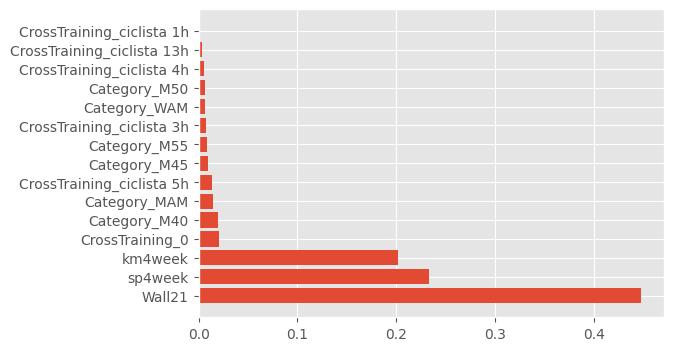

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(relevante.index, relevante['Relevante'] )
plt.show()

Reducimos el numero de observaciones que pueden llegar a generar dispersiones en los resultados.

In [ ]:
relevante_maraton = relevante[relevante['Relevante'] > 0.02].index
df_relevante_maraton = datos_maraton.loc[:, relevante_maraton.append(pd.Index(['MarathonTime']))]
df_relevante_maraton.head(5)

,Wall21,sp4week,km4week,CrossTraining_0,Category_M40,MarathonTime
0,1.16,14.43,132.80,1,0,2.37
1,1.23,13.67,68.60,1,0,2.59
2,1.30,13.52,82.70,1,0,2.66
3,1.32,12.26,137.50,1,0,2.68
4,1.36,13.95,84.60,1,0,2.74


Volvemos a probar los modelos con las observaciones que mostraron mas relevancia para un mejor resultado.

# Random Forest con RF selector

In [ ]:
random_forest_regression(df_relevante_maraton)

RMSE (train):  0.14005396606084927
RMSE (test):  0.15000038029118842
R2 Score (train):  0.8631618078939727
R2 Score (test):  0.8199608289761482
MAE (train):  0.11067999999999555
MAE (test):  0.12153499999999756


RandomForestRegressor(bootstrap=False, criterion='absolute_error',
                      max_features='sqrt', n_estimators=1000, random_state=10)

# XGBoost con RF selector

In [ ]:
xgboost_regression(df_relevante_maraton)

RMSE (train):  0.38624045997664
RMSE (test):  0.36837214728156786
R2 Score (train):  -0.04071553035936559
R2 Score (test):  -0.0858150468401182
MAE (train):  0.3173358617722988
MAE (test):  0.30980326294898985


Acotando los datos, se ve una mejoria en los valores de Ramdon Forest

In [ ]:
linear_regression(df_relevante_maraton)

RMSE (train):  0.09055698496588728
RMSE (test):  0.10931318656508876
R2 Score (train):  0.9427915194219418
R2 Score (test):  0.9043846996925735
MAE (train):  0.09549607907781368
MAE (test):  0.09549607907781368


Excluyendo las variables menos relevantes para el modelo, se consiguio una leve mejoria en los tres modelos